# PERT

"PERT is designed for news statement anal- ysis as well, but it is uniquely from a linguistic perspective. For effective analysis, we employ eight linguistic features, including Adjective ratio, Noun ratio, Verb ratio, Propn (such as Google, etc.) ratio, Sentiment score, Normalized text length, Whether contains the mark "?", Whether contains the mark "!"" (Yang, Pentyala, Mohseni, Du, Yuan, Linder, Ragan, Ji & Hu, 2019)

Yang, F., Pentyala, S. K., Mohseni, S., Du, M., Yuan, H., Linder, R., ... & Hu, X. (2019). XFake: explainable fake news detector with visualizations. In The World Wide Web Conference (pp. 3600-3604).

## Import packages

In [1]:
import csv
import pandas as pd
import numpy as np
import re
import spacy
import nltk
from textblob import TextBlob
from nltk.corpus import words
from nltk.tag import pos_tag
from unidecode import unidecode
from spacy.tokens import Doc
from spacy.language import Language
from matplotlib import pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
# import English language model
nlp = spacy.load("/opt/anaconda3/lib/python3.8/site-packages/en_core_web_sm/en_core_web_sm-2.3.1")

## Import data

In [3]:
# column names
column_names = ["id", "label", "statement", "subject", "speaker", "job title speaker", "state info", "party affiliation", "barely true counts", "false counts", "half true counts", "mostly true counts", "pants on fire counts", "context", "extracted justification"]

In [4]:
# import data
df = pd.read_table("data.csv", delimiter = ",",).reset_index(drop=True)

In [5]:
# select only what we need
df = df[['label', 'statement']]

In [6]:
# show dataframe
df.head()

,label,statement
0,false,Says the Annies List political group supports ...
1,half-true,When did the decline of coal start? It started...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo..."
3,false,Health care reform legislation is likely to ma...
4,half-true,The economic turnaround started at the end of ...


## Linguistic features (part 1)

* Normalized text length
* Whether contains the mark "?"
* Whether contains the mark "!"

In [7]:
# Normalized text length (min-max normalization)
df['length_statement'] = [len(statement) for statement in df['statement']]
df['normalized_statement_length'] = (df['length_statement']-df['length_statement'].min())/(df['length_statement'].max()-df['length_statement'].min())
df = df.drop(['length_statement'], axis=1)

In [8]:
# Whether contains the mark "?"
df['question_mark'] = [1 if s.find('?') != -1 else 0 for s in df['statement']]

In [9]:
# Whether contains the mark "!"
df['exclamation_mark'] = [1 if s.find('!') != -1 else 0 for s in df['statement']]

## Pre-processing (part 1)

* Remove extra whitespaces
* Convert accented characters to ASCII characters
* Expand contractions
* Expand abbreviations
* Remove special characters
* Remove numbers

In [10]:
# Remove extra whitespaces
df['statement'] = [' '.join(statement.split()) for statement in df['statement']]

In [11]:
# Convert accented characters to ASCII characters
df['statement'] = [unidecode(statement) for statement in df['statement']]

In [12]:
# Expanding contractions function

def expand_contractions(text):
    
    flags = re.IGNORECASE | re.MULTILINE
    
    text = re.sub(r'`', "'", text, flags = flags)
    text = re.sub(r"(\s|^)'(aight|cause)(\s|$)", '\g<1>\g<2>\g<3>', text, flags = flags)
    text = re.sub(r"(\s|^)'t(was|is)(\s|$)", r'\g<1>it \g<2>\g<3>', text, flags = flags)
    text = re.sub(r"(\s|^)ol'(\s|$)", '\g<1>old\g<2>', text, flags = flags)
    
    ## expand words without
    text = re.sub(r"\b(aight)\b", 'alright', text, flags = flags)
    text = re.sub(r'\bcause\b', 'because', text, flags = flags)
    text = re.sub(r'\b(finna|gonna)\b', 'going to', text, flags = flags)
    text = re.sub(r'\bgimme\b', 'give me', text, flags = flags)
    text = re.sub(r"\bgive'n\b", 'given', text, flags = flags)
    text = re.sub(r"\bhowdy\b", 'how do you do', text, flags = flags)
    text = re.sub(r"\bgotta\b", 'got to', text, flags = flags)
    text = re.sub(r"\binnit\b", 'is it not', text, flags = flags)
    text = re.sub(r"\b(can)(not)\b", r'\g<1> \g<2>', text, flags = flags)
    text = re.sub(r"\bwanna\b", 'want to', text, flags = flags)
    text = re.sub(r"\bmethinks\b", 'me thinks', text, flags = flags)
    
    ## one offs
    text = re.sub(r"\bo'er\b", r'over', text, flags = flags)
    text = re.sub(r"\bne'er\b", r'never', text, flags = flags)
    text = re.sub(r"\bo'?clock\b", 'of the clock', text, flags = flags)
    text = re.sub(r"\bma'am\b", 'madam', text, flags = flags)
    text = re.sub(r"\bgiv'n\b", 'given', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\be'er\b", 'ever', text, flags = flags)
    text = re.sub(r"\bd'ye\b", 'do you', text, flags = flags)
    text = re.sub(r"\bg'?day\b", 'good day', text, flags = flags)
    text = re.sub(r"\b(ain|amn)'?t\b", 'am not', text, flags = flags)
    text = re.sub(r"\b(are|can)'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(let)'?s\b", r'\g<1> us', text, flags = flags)
    
    ## major expansions involving smaller
    text = re.sub(r"\by'all'dn't've'd\b", 'you all would not have had', text, flags = flags)
    text = re.sub(r"\by'all're\b", 'you all are', text, flags = flags)
    text = re.sub(r"\by'all'd've\b", 'you all would have', text, flags = flags)
    text = re.sub(r"(\s)y'all(\s)", r'\g<1>you all\g<2>', text, flags = flags)
    
    ## minor
    text = re.sub(r"\b(won)'?t\b", 'will not', text, flags = flags)
    text = re.sub(r"\bhe'd\b", 'he had', text, flags = flags)

    ## major
    text = re.sub(r"\b(I|we|who)'?d'?ve\b", r'\g<1> would have', text, flags = flags)
    text = re.sub(r"\b(could|would|must|should|would)n'?t'?ve\b", r'\g<1> not have', text, flags = flags)
    text = re.sub(r"\b(he)'?dn'?t'?ve'?d\b", r'\g<1> would not have had', text, flags = flags)
    text = re.sub(r"\b(daren|daresn|dasn)'?t", 'dare not', text, flags = flags)
    text = re.sub(r"\b(he|how|i|it|she|that|there|these|they|we|what|where|which|who|you)'?ll\b", r'\g<1> will', text, flags = flags)
    text = re.sub(r"\b(everybody|everyone|he|how|it|she|somebody|someone|something|that|there|this|what|when|where|which|who|why)'?s\b", r'\g<1> is', text, flags = flags)
    text = re.sub(r"\b(I)'?m'a\b", r'\g<1> am about to', text, flags = flags)
    text = re.sub(r"\b(I)'?m'o\b", r'\g<1> am going to', text, flags = flags)
    text = re.sub(r"\b(I)'?m\b", r'\g<1> am', text, flags = flags)
    text = re.sub(r"\bshan't\b", 'shall not', text, flags = flags)
    text = re.sub(r"\b(are|could|did|does|do|go|had|has|have|is|may|might|must|need|ought|shall|should|was|were|would)n'?t\b", r'\g<1> not', text, flags = flags)
    text = re.sub(r"\b(could|had|he|i|may|might|must|should|these|they|those|to|we|what|where|which|who|would|you)'?ve\b", r'\g<1> have', text, flags = flags)
    text = re.sub(r"\b(how|so|that|there|these|they|those|we|what|where|which|who|why|you)'?re\b", r'\g<1> are', text, flags = flags)
    text = re.sub(r"\b(I|it|she|that|there|they|we|which|you)'?d\b", r'\g<1> had', text, flags = flags)
    text = re.sub(r"\b(how|what|where|who|why)'?d\b", r'\g<1> did', text, flags = flags)
    
    return text

In [13]:
# Expand contractions
df['statement'] = [expand_contractions(statement) for statement in df['statement']]

In [14]:
# Most common abbreviations

abbr = {'u.n.': 'united nations',
        'a.m.': 'before midday',
        'n.y.': 'new york',
        'e.u.': 'european union',
        'u.s.': 'united states',
        'u.k.': 'united kingdom',
        'd.c.': 'district columbia',
        'a.k.a.': 'also known as',
        'r.i.p.': 'rest in peace',
        'n.h.': 'new hampshire',
        'r.i.': 'rhode island',
        's.c.': 'south carolina',
        
        'gop': 'the republican party',
        'usa': 'united states of america',
        'nato': 'north atlantic treaty organization',
        'epa': 'environmental protection agency',
                 
        'rep.': 'representative',
        'reps.': 'representatives',
        'dem.': 'democrat',
        'tenn.': 'tennessee',
        'capt': 'captain',
        'gov.': 'government',
        'sen.': 'senator',
        'mr.': 'mister',
        'ok': 'okay',
        'gen.': 'general',
        'jr.': 'junior',
       }

In [15]:
# Abbrevation function

def expand_abbreviations(text):

    for key, value in abbr.items():
        if key in text:
            text = text.replace(key, value)
    
    return text

In [16]:
# Expand abbreviations
df['statement'] = [expand_abbreviations(statement) for statement in df['statement']]

In [17]:
# Remove special characters
df['statement'] = [re.sub(r"[^a-zA-Z0-9]+", ' ', statement) for statement in df['statement']]

In [18]:
# Remove numbers
df['statement'] = [re.sub(" \d+", " ", statement) for statement in df['statement']]

## Linguistic features (part 2)

* Adjective ratio (bijvoeglijk naamwoord)
* Noun ratio (zelfstandig naamwoord)
* Verb ratio (werkwoord)
* Propn (such as Google, etc.) ratio

In [19]:
# num of words
df['num_words'] = [len(word.split()) for word in df['statement']]
df['sort_words'] = [" ".join([token.pos_ for token in nlp(statement)]) for statement in df['statement']]

In [20]:
# ADJ
df['ADJ_num'] = [sum(1 for _ in re.finditer(r'\b%s\b' % re.escape('ADJ'), sw)) for sw in df['sort_words']]
df['ADJ_ratio'] = df['ADJ_num'] / df['num_words']

In [21]:
# NOUN
df['NOUN_num'] = [sum(1 for _ in re.finditer(r'\b%s\b' % re.escape('NOUN'), sw)) for sw in df['sort_words']]
df['NOUN_ratio'] = df['NOUN_num'] / df['num_words']

In [22]:
# VERB
df['VERB_num'] = [sum(1 for _ in re.finditer(r'\b%s\b' % re.escape('VERB'), sw)) for sw in df['sort_words']]
df['VERB_ratio'] = df['VERB_num'] / df['num_words']

In [23]:
# PROPN
df['PROPN_num'] = [sum(1 for _ in re.finditer(r'\b%s\b' % re.escape('PROPN'), sw)) for sw in df['sort_words']]
df['PROPN_ratio'] = df['PROPN_num'] / df['num_words']

In [24]:
# remove excess
df = df.drop(columns=['num_words', 'sort_words', 'ADJ_num', 'NOUN_num', 'VERB_num', 'PROPN_num'])

## Pre-processing (part 2)

* Lowercase all texts
* Lemmatization

In [25]:
# Lowercase all texts
df['statement'] = [statement.lower() for statement in df['statement']]

In [26]:
# lemmatization
df['statement'] = [" ".join([token.lemma_ for token in nlp(statement)]) for statement in df['statement']]

## Linguistic features (part 3)

* Sentiment score

In [27]:
# sentiment score (polarity)
df['sentiment_score'] = [TextBlob(statement).sentiment.polarity for statement in df['statement']]

## Re-labelling

"Particularly, labels with Mostly True, Half True, No Flip, Half Flip are switched to label True, and labels with Mostly False, Pants On Fire, Full Flop are switched to label False." -- barely true

In [28]:
# true
df['label'] = df['label'].replace(['mostly-true','half-true', 'barely-true', 'no-flip', 'half-flip'], 'true')

In [29]:
# false
df['label'] = df['label'].replace(['mostly-false','pants-fire', 'full-flop'], 'false')

In [30]:
# value counts
df['label'].value_counts()

true     9260
false    3560
Name: label, dtype: int64

## XGBoost

In [31]:
df.head()

,label,statement,normalized_statement_length,question_mark,exclamation_mark,ADJ_ratio,NOUN_ratio,VERB_ratio,PROPN_ratio,sentiment_score
0,false,say the annie list political group support thi...,0.023698,0,0,0.166667,0.333333,0.166667,0.166667,0.0
1,true,when do the decline of coal start -PRON- start...,0.043391,1,0,0.041667,0.250000,0.125000,0.166667,0.1
2,true,hillary clinton agree with john mccain by vote...,0.031375,0,0,0.000000,0.105263,0.157895,0.368421,0.0
3,false,health care reform legislation be likely to ma...,0.022363,0,0,0.166667,0.583333,0.083333,0.000000,0.2
4,true,the economic turnaround start at the end of -P...,0.014352,0,0,0.100000,0.300000,0.100000,0.000000,0.2


In [32]:
# y variable
y = df['label']

In [33]:
# x variables
x = df[['normalized_statement_length', 'question_mark','exclamation_mark', 'ADJ_ratio', 'NOUN_ratio', 'VERB_ratio','PROPN_ratio', 'sentiment_score']]

In [34]:
# split dat in train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [35]:
# fit model to training data
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
# make predictions for test data
y_pred = model.predict(x_test)
predictions = [value for value in y_pred]

In [37]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.79%


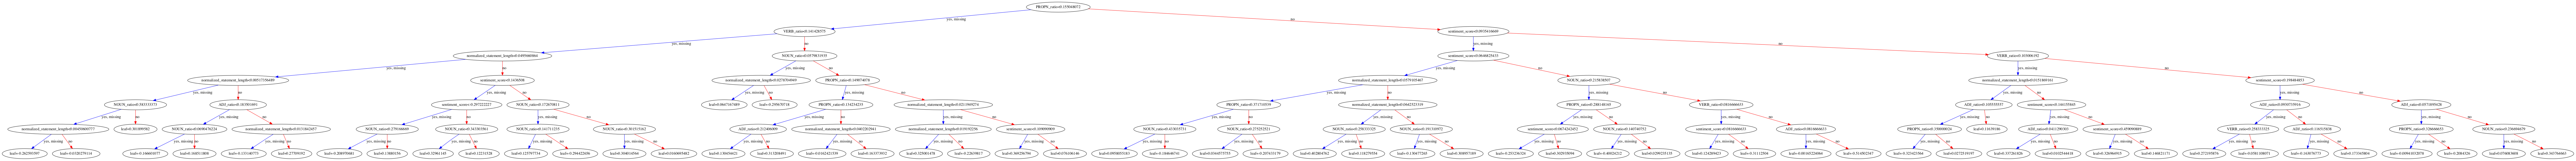

In [38]:
# save and show decision tree
fig, ax = plt.subplots(figsize=(300, 300))
xgb.plot_tree(model, num_trees=2, ax=ax)
plt.savefig("temp.png")
plt.show()

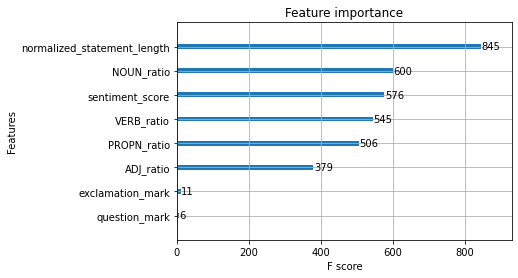

In [39]:
# show feature importance
plot_importance(model)
plt.show()